In [ ]:
## Mini-Project: An End-to-End Churn Prediction Model Using AWS
Churn prediction is a crucial aspect for businesses, especially those operating in subscription-based models or industries with high customer turnover. Churn refers to the phenomenon where customers discontinue using a product or service. Predicting churn is important for several reasons:

Revenue Impact:

- Retaining existing customers is often more cost-effective than acquiring new ones. Losing customers means losing the associated revenue. Churn prediction helps businesses identify customers at risk of leaving so that proactive measures can be taken to retain them.
Resource Allocation:

- By predicting which customers are likely to churn, businesses can allocate resources more efficiently. They can concentrate efforts and resources on retaining high-value customers who are at a higher risk of leaving, rather than applying blanket retention strategies.
Customer Experience Improvement:

- Understanding why customers churn provides valuable insights into areas that may need improvement. It could be issues related to product quality, customer service, or competitive factors. Identifying and addressing these issues can enhance overall customer experience.
                                                                                                                                                                                                                                                                            
In this mini-project, an end-to-end churn prediction model using AWS's SageMaker is built. Amazon SageMaker is a fully managed service that simplifies the process of building, training, and deploying machine learning models at scale. It's designed to make it easier for developers to build, train, and deploy machine learning models in a production environment.

Install packages 

In [ ]:
%pip install s3fs

In [13]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    amazon-q-developer-jupyterlab-ext-3.4.3|     pyhd8ed1ab_0         240 KB  conda-forge
    amazon-sagemaker-jupyter-ai-q-developer-1.0.14|     pyhd8ed1ab_0          81 KB  conda-forge
    amazon-sagemaker-jupyter-scheduler-3.1.7|     pyhd8ed1ab_0         169 KB  conda-forge
    amazon_sagemaker_sql_editor-0.1.13|     pyhd8ed1ab_0        17.0 MB  conda-forge
    fastapi-0.115.4            |     pyhff2d567_1          72 KB  conda-forge
    ipython-8.29.0             |     pyh707e725_0         585 KB  conda-forge
    jupyter-ai-2.28.0          |     pyhd8ed1ab_0         739 KB  conda-forge
    jupyter-ai-magics-2.28.0   |     pyhd8ed1ab_0          35 KB  conda-forge
    jupyter-coll

Import the needed packages

In [15]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

Studio notebook to preprocess the dataset and upload it to S3 bucket

In [1]:
import boto3
import pandas as pd
import numpy as np


# Preprocess the dataset
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Convert to datetime columns
    df["firstorder"] = pd.to_datetime(df["firstorder"], errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"], errors='coerce')
    # Drop Rows with null values
    df = df.dropna()
    # Create Column which gives the days between the last order
    # and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    # Create Column which gives the days between when the customer record was
    # created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff'] = (df['created']-df['firstorder']).dt.days
    # Drop Columns
    df.drop(['custid', 'created', 'firstorder', 'lastorder'],
            axis=1, inplace=True)
    # Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df, prefix=['favday', 'city'],
                        columns=['favday', 'city'])
    return df


# Set the required configurations
model_name = "churn_model"
env = "dev"
# S3 Bucket
default_bucket = "ucsdbootcampherath"
# Preprocess the dataset
print(f"s3://{default_bucket}/storedata_total.csv")
storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.csv")

s3://ucsdbootcampherath/storedata_total.csv


In [5]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [ ]:
storedata.columns

In [ ]:
storedata.info()

In [22]:
storedata.describe()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,created_first_days_diff
count,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000,30758.000000
mean,0.794558,28.135314,25.556458,5.674711,61.848370,0.037765,0.649197,0.095032,0.038949,82.547435,-34.341927
std,0.404031,16.751419,29.556563,10.565884,40.952687,0.103985,0.477229,0.293264,0.193477,616.066113,544.935933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41526.000000,-1998.000000
25%,1.000000,16.000000,2.083333,0.000000,40.020000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.000000
50%,1.000000,32.000000,13.207547,0.000000,50.960000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
75%,1.000000,42.000000,40.000000,7.142857,74.260000,0.040896,1.000000,0.000000,0.000000,46.000000,0.000000
max,1.000000,291.000000,100.000000,100.000000,2600.140000,3.250000,1.000000,1.000000,1.000000,1985.000000,41553.000000


Develop the baseline model

In [25]:
# Split data to train, test and validate sets:
def split_datasets(df):
    y = df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y), 1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre, X_pre), axis=1)
    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(.7*len(X)), int(.85*len(X))])
    return feature_names, train, validation, test


# Split dataset
feature_names, train, validation, test = split_datasets(storedata)


In [25]:
# Save datasets in Amazon S3
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/train.csv",
                           header=False, index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/validation.csv",
                                header=False, index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/test.csv",
                          header=False, index=False)

In [2]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


Train, tune, and find the best candidate model

In [3]:
import sagemaker
from sagemaker.session import TrainingInput
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner

# Training and Validation Input for SageMaker Training job
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/", content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/", content_type="csv")

# Hyperparameter used
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

region = boto3.Session().region_name
role = sagemaker.get_execution_role()

# Use the built-in SageMaker algorithm
sagemaker_session = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(estimator, objective_metric_name,
                            hyperparameter_ranges, max_jobs=10, 
                            max_parallel_jobs=2)

# Tune
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    }, include_cls_metadata=False)

## Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)
# 10 training jobs have completed

# Get the best training job

from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................!
10 training jobs have completed
Best Model found so far:
{'CreationTime': datetime.datetime(2024, 11, 9, 18, 24, 26, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9789620041847229},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 11, 9, 18, 26, 49, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:676206908819:training-job/sagemaker-xgboost-241109-1824-002-d0298fb4',
 'TrainingJobName': 'sagemaker-xgboost-241109-1824-002-d0298fb4',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 11, 9, 18, 25, 10, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.8354266424955727',
                          'eta': '0.11294726389355991',
                          'max_depth': '4',
                          'min_child_weight': '8.5533921019

Get the best hyperparameters so far

In [4]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [5]:
best_hyperparameters

{'alpha': '1.8354266424955727',
 'eta': '0.11294726389355991',
 'max_depth': '4',
 'min_child_weight': '8.553392101975371'}

In [6]:
hyperparameters = {**fixed_hyperparameters, any**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

Get the URI (Uniform Resource Identifier) for a specific container image hosted by AWS
Container type: 'xgboot'
XGBoost framework version: '0.90-2'

In [8]:
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

Use the container URI for creating an Estimator to train an XGBoost model

In [16]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

Train a model using the input training dataset.

In [17]:
estimator.fit({"train": s3_input_train, "validation": s3_input_validation}, wait=False)

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-11-09-20-36-47-540


In [18]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress


Analyze Debugger Output

In [19]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:676206908819:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-bd1d55b6',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 11, 9, 20, 41, 52, 590000, tzinfo=tzlocal())}]

In [20]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-11-09 21:37:07.686 default:1974 INFO s3_trial.py:42] Loading trial debug-output at path s3://ucsdbootcampherath/debugger/demo-smdebug-xgboost-churn-classificati-2024-11-09-20-36-47-540/debug-output


In [21]:
trial.tensor_names()

[2024-11-09 21:37:17.543 default:1974 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-09 21:37:18.558 default:1974 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [22]:
trial.tensor("average_shap/f1").values()

{0: array([-1.2671556e-05], dtype=float32),
 5: array([-0.00147512], dtype=float32),
 10: array([0.00141619], dtype=float32),
 15: array([0.00931612], dtype=float32),
 20: array([0.01144488], dtype=float32),
 25: array([0.00831688], dtype=float32),
 30: array([0.00853086], dtype=float32),
 35: array([0.01319934], dtype=float32),
 40: array([0.02297943], dtype=float32),
 45: array([0.03373932], dtype=float32),
 50: array([0.04454654], dtype=float32),
 55: array([0.06365519], dtype=float32),
 60: array([0.06976821], dtype=float32),
 65: array([0.07610431], dtype=float32),
 70: array([0.09079248], dtype=float32),
 75: array([0.09528249], dtype=float32),
 80: array([0.09779596], dtype=float32),
 85: array([0.10612816], dtype=float32),
 90: array([0.10581652], dtype=float32),
 95: array([0.10773486], dtype=float32)}

In [26]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

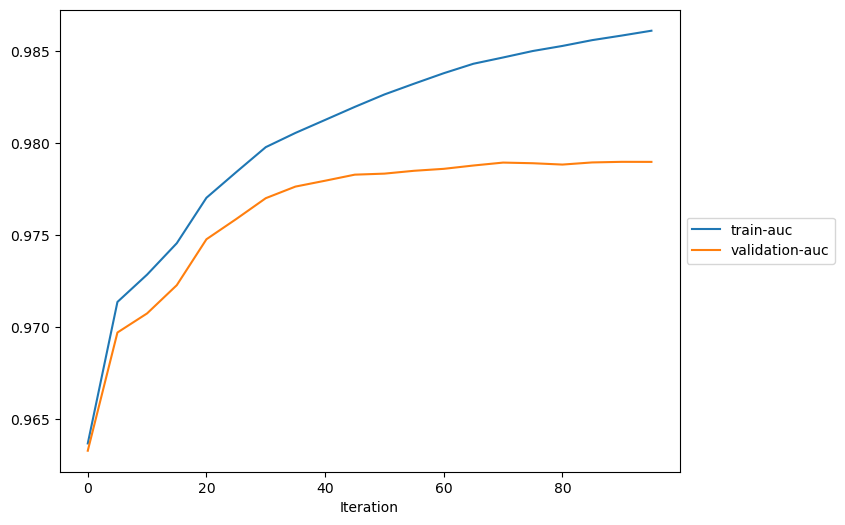

In [27]:
plot_collection(trial, "metrics")

The AUC for train set reaches 0.985 (and increasing trend) while the AUC for validation set is approximately 0.977. While the difference is small (0.01), the validation AUC is saturated and training AUC shows an increasing trend. This shows a trend of model overfitting.  

"weight": Number of times a feature is used to split data across all trees.
"gain": Average gain (improvement in loss function) from splits using the feature.
"cover": Coverage or average number of samples affected by splits using the feature.
"total_gain": Sum of gain for each feature across all trees.
"total_cover": Sum of cover for each feature across all trees.

In [28]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

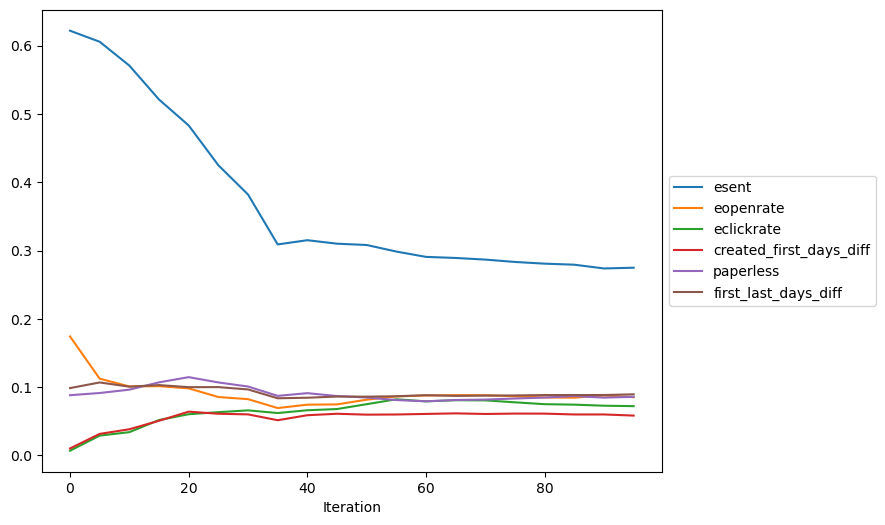

In [29]:
plot_feature_importance(trial, importance_type="cover")

Shapley values to determine the contribution that each feature made to model predictions

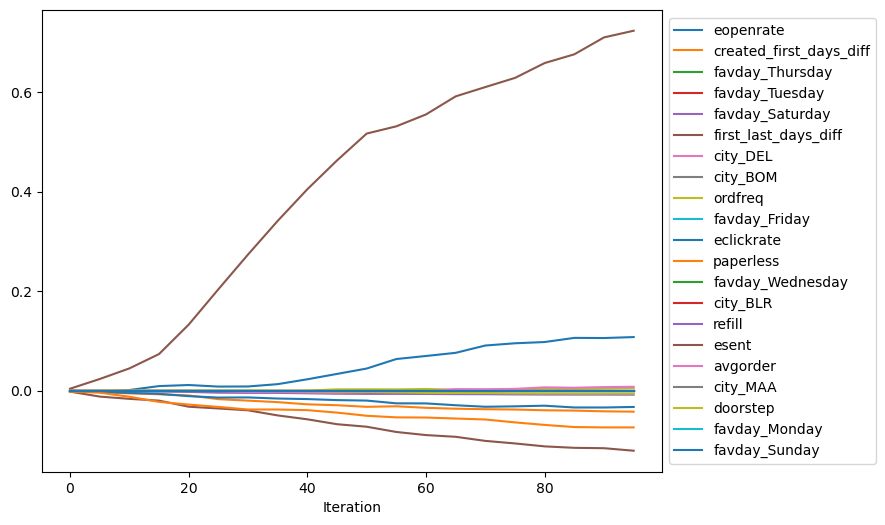

In [31]:
plot_collection(trial, "average_shap")

esent: Number of emails sent shows the highest contributor to the model predictions. 

Global Explanations

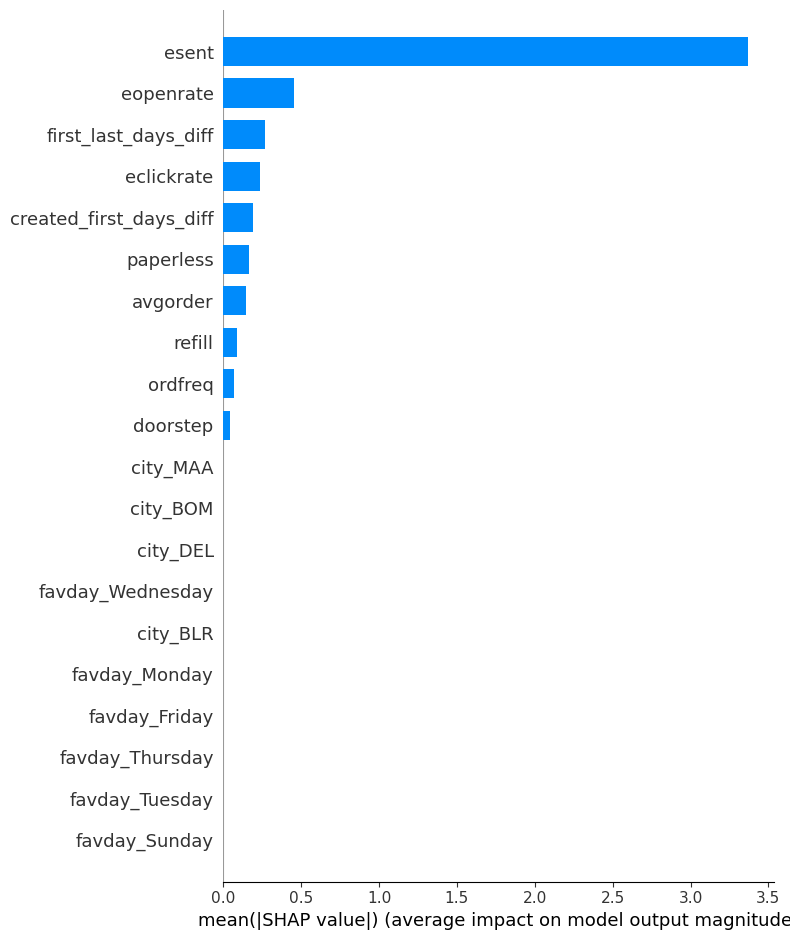

In [32]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [35]:
shap_values

array([[ 3.2511818 , -0.33662304, -0.2823559 , ...,  0.        ,
         0.        ,  2.0677464 ],
       [-1.0859721 , -0.41473466,  0.20465945, ...,  0.        ,
         0.        ,  2.0677464 ],
       [-0.9216728 , -0.12055226,  0.41080314, ...,  0.        ,
         0.        ,  2.0677464 ],
       ...,
       [ 1.0963796 ,  0.07877192,  0.50040525, ...,  0.        ,
         0.        ,  2.0677464 ],
       [ 2.733547  ,  0.15005708,  0.48803696, ...,  0.        ,
         0.        ,  2.0677464 ],
       [ 2.855295  ,  0.20034827, -0.01229425, ...,  0.        ,
         0.        ,  2.0677464 ]], dtype=float32)

In [36]:
train_shap = pd.DataFrame(train[:,1:], columns=feature_names)

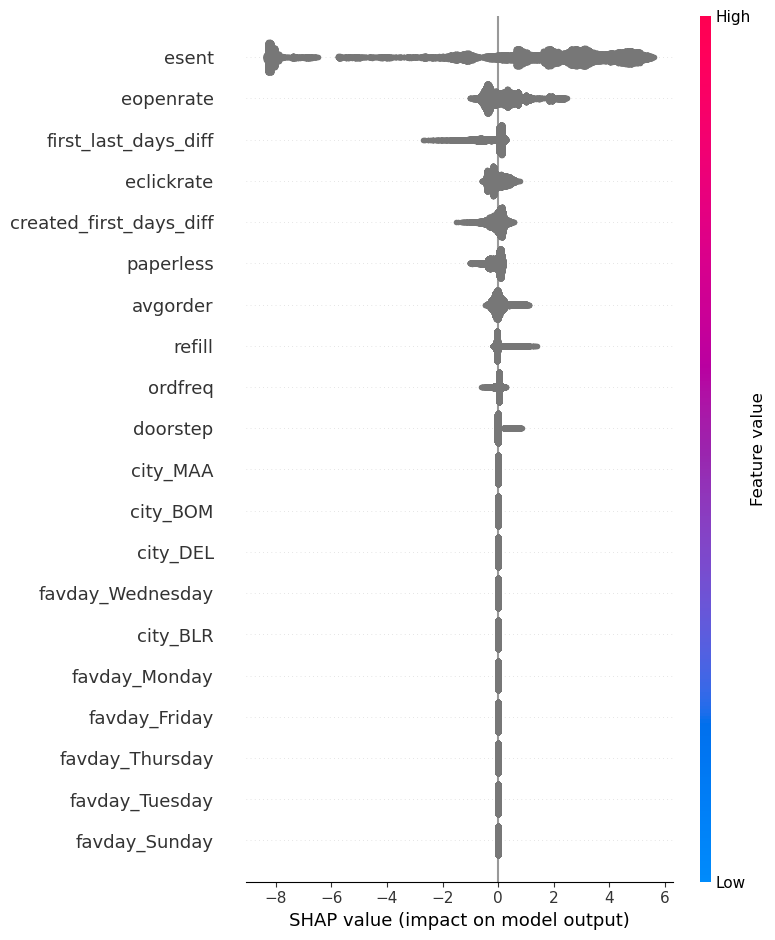

In [37]:
shap.summary_plot(shap_no_base, train_shap)

In [38]:
shap.initjs()

In [39]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [40]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [41]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)

## Mini-Project: An End-to-End Churn Prediction Model Using AWS
As seen in this Jupyter Notebook, AWS SageMaker can be used to build an end-to-end churn prediction model. The fully managed SageMaker simplifies the process of building, training, and deploying machine learning models.


Resources: 
https://aws.amazon.com/blogs/machine-learning/build-tune-and-deploy-an-end-to-end-churn-prediction-model-using-amazon-sagemaker-pipelines/ 
https://github.com/aws-samples/customer-churn-sagemaker-pipelines-sample/tree/main